### Import libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft # For the fourier transform
from scipy.interpolate import griddata # For the interpolation
from scipy.optimize import curve_fit

### Define functions

- `load_data` takes in a DEM in .txt form and outputs a numpy array of x, y, z vectors
- `interpolate` takes in an unsorted array of points and fits the data to a regular grid (reconstructs DEM)
- `psd` computes the average power series density (PSD) of each row ($\pm x$ direction) of the input grid
- `plot_psd_log` plots the PSD against the corresponding wavenumbers in log-log space and computes the Hurst exponent

In [14]:
def load_data(path):
    """
    Loads the data from a text file. 
    Columns 1, 2, 3 should be the x, y, z coordinates respectively.
    The separator should be a space.
    Slip direction should be aligned in the x direction.
    The normal direction should be aligned in the z direction.

    Input:
    path: The path to the text file.

    Output:
    data: The data from the text file.
    """

    data = np.loadtxt(path, usecols=(0,1,2)) # Only x, y, z coordinates
    return data

def interpolate(raw_data):
    """
    Interpolates the data onto a regular grid.

    Input:
    raw_data: The raw data to be interpolated. 
    Should be a numpy array with 3 columns, where the first two columns are the x and y coordinates, 
    and the third column is the z coordinate.

    Output:
    fit_data: Data interpolated onto a regular grid.
    """

    # Spacing of the grid
    # Calculated by taking the difference between the first two points
    x_spacing = abs(round(raw_data[0,0] - raw_data[1,0], 3)) # Round to 2 decimal places
    y_spacing = abs(round(raw_data[0,1] - raw_data[1,1], 3))

    # Length of the grid in x and y
    # Calculated by taking the difference between the first and last points
    x_length = abs(round(raw_data[0,0] - raw_data[-1,0], 3))
    y_length = abs(round(raw_data[0,1] - raw_data[-1,1], 3))
    
    # Create a regular grid using meshgrid
    # Here, length // spacing = number of points
    x = np.linspace(np.min(raw_data[:,0]), np.max(raw_data[:,0]), int(x_length // x_spacing)) 
    y = np.linspace(np.min(raw_data[:,1]), np.max(raw_data[:,1]), int(y_length // y_spacing))
    X, Y = np.meshgrid(x, y)

    # Interpolate the data onto the grid
    # fit_data[0] is the bottom row, fit_data[-1] is the top row. fit_data[:,0] is the left column, fit_data[:,-1] is the right column. 
    # Index row by row by going from fit_data[0] to fit_data[-1] for fft.
    fit_data = griddata(raw_data[:,0:2], raw_data[:,2], (X, Y), method='linear')

    # Remove any NaN values by replacing them with the mean of the data
    fit_data = np.nan_to_num(fit_data, nan=np.nanmean(fit_data))

    # # Plot the data
    # plt.contourf(X, Y, fit_data, 100, cmap='jet')
    # plt.colorbar()
    # plt.show()

    return fit_data

def psd(data_array):
    """
    Performs an FFT row by row on the input array. Each FFT output is then converted to PSD as a function of wavenumber (1 / frequency).
    
    """

    # Perform the FFT on each row
    fft_data = np.fft.fft(data_array, axis=1)
    
    # Calculate the PSD from the FFT data (only the real part is needed)
    psd_data = np.abs(fft_data)**2

    # Take the mean psd of all the rows
    psd_data = np.mean(psd_data, axis=0)
    
    # Calculate the wavenumber (reciprocal of frequency)
    # The wavenumber is the same for each row, so we can just calculate it once
    wavenumber = np.fft.fftfreq(len(data_array[0]))

    # Remove the negative (and 0) wavenumbers and corresponding psd data
    # This is because 1) the PSD is symmetry about 0 and 
    # 2) We have to take the log of each value later
    psd_data = psd_data[wavenumber > 0]
    wavenumber = wavenumber[wavenumber > 0]
    
    return wavenumber, psd_data


def plot_psd_log(wavenumber, psd_data):
    """
    Plots the PSD data as a function of wavenumber on a log-log scale.

    Input:
    wavenumber: The wavenumber data.
    psd_data: The PSD data.
    """

    def hurst(wv, ps):
        """
        Hurst Exponent
        """
        # Fit a line to the log of the data
        def func(x, a, b): return a*x + b # Linear function
        popt, pcov = curve_fit(func, np.log(wv), np.log(ps)) # Fit

        # Calculate the Hurst exponent (slope + 1) / -2
        hurst = (popt[0] + 1) / -2

        # Calculate error
        perr = np.sqrt(np.diag(pcov))

        return hurst, perr[0]

    if isinstance(wavenumber[0], np.ndarray): # If the wavenumber is a 2D array, i.e. multiple scans
        # Plot each scan on the same plot

        for i in range(len(wavenumber)):
            hurst_exp, hurst_err = hurst(wavenumber[i], psd_data[i])
            plt.scatter(wavenumber[i], psd_data[i], label=f'Scan {i+1}, HE= {round(hurst_exp, 3)} +/- {round(hurst_err, 3)}')

        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Wavenumber')
        plt.ylabel('PSD')
        plt.title('PSD as a function of wavenumber')
        plt.legend()
        plt.show()
        
    else:

        plt.scatter(wavenumber, psd_data)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Wavenumber')
        plt.ylabel('PSD')
        plt.title('PSD as a function of wavenumber')
        plt.show()


### Execute (Will be streamlined later)

In [11]:
# List of files
prefix = '../surfaces/'
suffix = '.txt'
file_list = ['AVLY01/AVLY01_S1', 'AVLY01/AVLY01_S2', 'AVLY02/AVLY02', 'AVLY03/AVLY03', 'AVLY04/AVLY04', 'AVLY05/AVLY05']

# Initiate lists
name_list = []
wn_list = []
psd_list = []
hurst_list = []

# Load data 
for file in file_list:
    path = prefix + file + suffix
    data = load_data(path)

    # Compute
    fit_data = interpolate(data)
    wn, ps = psd(fit_data)

    # Append to lists
    name_list.append(file)
    wn_list.append(wn)
    psd_list.append(ps)

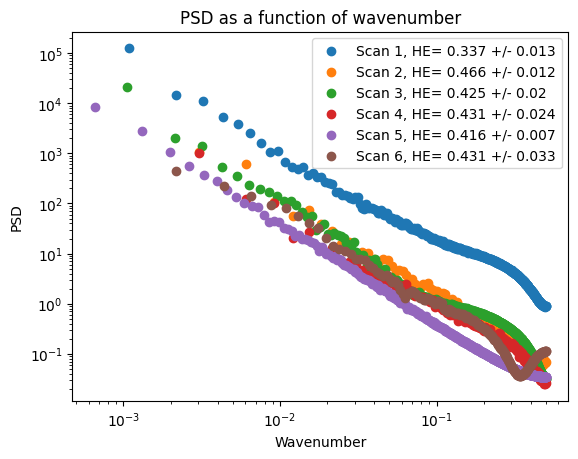

In [15]:
plot_psd_log(wn_list, psd_list)

In [42]:
def plot_fourier(data_array):
    # Plot the fourier transform of the data
    fft_data = np.fft.fft(data_array, axis=1)

    # Take the mean of all the rows
    fft_data = np.mean(fft_data, axis=0)

    # Calculate the wavenumber (reciprocal of frequency)
    # The wavenumber is the same for each row, so we can just calculate it once
    wavenumber = np.fft.fftfreq(len(data_array[0]))

    fft_data = fft_data[wavenumber > 0]
    wavenumber = wavenumber[wavenumber > 0]

    # Only real part
    fft_data = np.abs(fft_data)

    plt.plot(wavenumber, fft_data)
    plt.xlim(0, 0.1)
    
    plt.show()


plot_fourier(gridded_data) # Plot the fourier transform of the data

NameError: name 'gridded_data' is not defined